## METFUT Load and Regrid ERA5 Data

THis notebook provides procedures to download, regrid and display ERA5 datasets from the Copernicus Data Storage using the CDS api. These procedures were developed to support METFUT in their goal to train ML models on subsets of ERA5 data.


For the cds API to work properly you will need to register an account at the [Copernicus Data Store](https://cds.climate.copernicus.eu/user/register?destination=%2F%23!%2Fhome) and create a file in your ```$HOME/``` directory called ```.cdsapirc``` which contains your API key (which you can find at the bottom of your personal profile) in the following format:
```
url: https://cds.climate.copernicus.eu/api/v2
key: {uid}:{api-key}
```

For this notebook to work you will need the following python modules installed in your python kernel:
- cdsapi
- xarray
- numpy
- pandas
- matplotlib
- cartopy
- netCDF4
- requests

please use the following command to install these packages:

```pip install cdsapi xarray numpy pandas matplotlib cartopy netCDF4 requests```

In [1]:
#import statements
import os, time
import cdsapi
import requests as rq
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from datetime import datetime


#create cds client
cds = cdsapi.Client()

## User Input
Change the following strings to correspond to your project path. The project_path defines the base project path in which the in_file and grid_file are located and where the out_file will be saved to. The in_file, grid_file and out_file paths are the file paths from the base path. This Jupyter Notebook should be located in the base porject path.

If you are working on a Windows machine you will need to install a linux subsystem using wsl (https://learn.microsoft.com/en-us/windows/wsl/install). In this case set the wsl variable to True. If you are on a Unix (macOs or Linux machine) set this to false. Make sure you have CDO installed either on the linux subsystem if using wsl or on your machine if using a Unix machine. (https://code.mpimet.mpg.de/projects/cdo/wiki/Win32)


You can download the icon grid files from the [ICON - Grid File Server](http://icon-downloads.mpimet.mpg.de/dwd_grids.xml) or use the downloadGridFile method below.

In [2]:
#the path to your project on your machine. Depending on if you are working on a linux, mac or windows machine, this path will look very different. When working on Unix system set this to "./". When working on windows with wsl use the subsystem terminal to navigate to the project folder and use the "pwd" command to print the current path.
project_path = "/mnt/c/users/maoka/PycharmProjects/EarthSystemDataProcessing/ESDP1/"

#the path to the directory to which the data is downloaded from the CDS, that we want to regrid and the name of the file we want to regrid
in_file = "input/t2m_230101_9-21_5-625.nc"

#the path to the ouput directory where the regridded data is saved and the name of the regridded file
out_file = "output/icon_t2m_230101_9-21_5-625.nc"

#the path to where the various files containing the information about the grid we want to regrid to is stored and the name of the grid file we want to regrid to
grid_file = "grids/icon_grid_0020_R03B06_G.nc"

#wether or not you are using the windows wsl linux subsystem. if you are working on a Unix (macOs or Linux machine set this to false)
wsl = True

Defining functions that can be used by the user:

In [3]:
def downloadFromCDS(file_name, date_string, time_string, step_string, param_string, grid_string):
    """
    Downloads data from CDS and saves it as netcdf file to the specified location (file_path) with the specified name (file_name).
    
    :param file_name: the path from the current directory to the downloaded data file 
    :param date_string: a string specifying the date of the data to be downloaded "YYYY-MM-DD/YYYY-MM-DD" (e.g. 2023-01-01/2023-01-02 for the 1st and 2nd of january) 
    :param time_string: a string specifying the time of the data to be downloaded "HH:MM:SS/HH:MM:SS" (e.g. 09:00:00/21:00:00 for 9 am and 9 pm)
    :param step_string: a string specifying the hourly time step from the specified time (time_string) that should be additionally downloaded between 0 and 12. (e.g. "0" for just the specified times in time_string, "0/4/8" for the times 9am, 1pm,5pm, 9pm, 1am, 5am)
    :param param_string: the string of the parameter variable to be downloaded (e.g. "167.128" for 2 meter temperature or "168.128" for 2 meter dewpoint temperature)
    :param grid_string: a string specifying the grid resolution to be downloaded in latitude and longitude format (e.g. 5.625/5.625 for 5.625 degree resolution)
    :return: empty return statement
    """
    
    print(time.time())
    cds.retrieve("reanalysis-era5-complete", {
        "class": "ea",
        "date": f'{date_string}',
        "expver": "1",
        "levtype": "sfc",
        "grid": f'{grid_string}',
        "param": f'{param_string}',
        "step": f'{step_string}',
        "stream": "oper",
        "time": f'{time_string}',
        "type": "4v",
        "format": "netcdf",
    }, f'{file_name}')
    print(time.time())

    return


def downloadGridFile(grid_name):
    requestPath = os.path.join("http://icon-downloads.mpimet.mpg.de/grids/public/edzw/", "icon_grid_0002_R02B06_G.nc")
    r = rq.get(requestPath)
    
def limitLatLon():
    
    pass


def convertGridToIconGrid(project_path, in_name, out_name, grid_name, wsl):
    """
    Converts the grid of an input file to the grid specified by grid_path and grid_name and saves it in out_path + out_name. If cdo runs on wsl because you are using a Windows machine you set wsl to true.

    :param project_path: the base path of the project, needed for cdo to properly find the files defined in in_name, out_name and grid_name
    :param in_name: file name of the input .nc file to be converted
    :param out_name: file name under which the output file should be saved
    :param grid_name: file name of the grid file that we want the in file to be converted
    :param wsl: boolean flag specifying whether to use WSL or not.
    
    :return: empty
    """

    infile = os.path.join(project_path, in_name)
    outfile = os.path.join(project_path, out_name)
    gridfile = os.path.join(project_path, grid_name)

    cmd = f"{'wsl' if wsl else ''} cdo remapbil,{gridfile} -setgridtype,curvilinear {infile} {outfile}"
    print(cmd)
    time_start = time.time()
    print(time_start)
    !{cmd}
    time_end = time.time()
    print(time_end)
    return


def plotIconTemperatureGraph(ds, step):
    """
    plotIconTemperatureGraph plots the t2m data in the ds file for the specified time (step is index of time array).

    :param ds: data object of a icongrid data object that contains our t2m information
    :param step: the index of the time array which specifies the time that we want to plot
    
    :return: empty
    """

    ti = ds["time"].values[step]
    date_time_obj = ti.astype("datetime64[ms]").astype(datetime).strftime('%Y-%m-%d %H:%M:%S')
    var = ds["t2m"].values[step]
    var = var - 273.15
    clon = np.rad2deg(ds.clon.values)
    clat = np.rad2deg(ds.clat.values)
    varMin, varMax, varInt = np.floor(np.nanmin(var)), np.ceil(np.nanmax(var)), 1
    levels = np.arange(-50, 51, 2)
    nlevs = levels.size
    print('')
    print('Cells:            %6d ' % clon.size)
    print('Variable min/max: %6.2f ' % np.nanmin(var) + '/' + ' %.2f' % np.nanmax(var))
    print('Contour  min/max: %6.2f ' % varMin + '/' + ' %.2f' % varMax)
    print('Date and Time:    %10s ' % date_time_obj)
    print('')
    projection = ccrs.PlateCarree()
    cmap = plt.get_cmap('Spectral_r', nlevs)
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=projection))
    ax.set_global()
    ax.gridlines(draw_labels=True, linewidth=0.5, color='dimgray', alpha=0.4, zorder=2)
    ax.coastlines(linewidth=0.5, zorder=2)
    plt.title(f"Surface Temperature at {date_time_obj}")
    cnf = ax.tricontourf(clon, clat, var, vmin=-60, vmax=60, levels=levels, cmap=cmap, extend='neither',
                         zorder=0)
    cbar_ax = fig.add_axes([0.2, 0.25, 0.6, 0.015], autoscalex_on=True)
    cbar = fig.colorbar(cnf, cax=cbar_ax, orientation='horizontal')
    cbar_ticks = levels[::10]
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels([f'{tick}' for tick in cbar_ticks])
    cbar.set_label('[deg C]')
    return


Example execution of the workflow:

In [4]:
downloadFromCDS(file_name=in_file, date_string="2023-01-01", time_string="09:00:00/21:00:00", step_string="0", param_string="167.128", grid_string="5.625/5.625")

1716035038.8511517


2024-05-18 14:23:59,567 INFO Welcome to the CDS
2024-05-18 14:23:59,567 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-complete
2024-05-18 14:23:59,630 INFO Request is completed
2024-05-18 14:23:59,630 INFO Downloading https://download-0009-clone.copernicus-climate.eu/cache-compute-0009/cache/data3/adaptor.mars.external-1715896916.3052025-20969-5-8538b9b2-8189-4aca-8c03-7185f3bfad5f.nc to input/t2m_230101_9-21_5-625.nc (9.7K)
2024-05-18 14:24:00,264 INFO Download rate 15.3K/s


1716035040.2957194


In [5]:
convertGridToIconGrid(project_path=project_path, in_name=in_file, out_name=out_file, grid_name=grid_file, wsl=wsl)

wsl cdo remapbil,/mnt/c/users/maoka/PycharmProjects/EarthSystemDataProcessing/ESDP1/grids/icon_grid_0020_R03B06_G.nc -setgridtype,curvilinear /mnt/c/users/maoka/PycharmProjects/EarthSystemDataProcessing/ESDP1/input/t2m_230101_9-21_5-625.nc /mnt/c/users/maoka/PycharmProjects/EarthSystemDataProcessing/ESDP1/output/icon_t2m_230101_9-21_5-625.nc
1716035040.3158436
cdo(1) setgridtype: Process started
cdo    remapbil: Bilinear weights from curvilinear (64x33) to unstructured (737280) grid
cdo(1) setgridtype: Processed 4224 values from 1 variable over 2 timesteps.
cdo    remapbil: Processed 4224 values from 1 variable over 2 timesteps [5.70s 367MB].
1716035046.1935234


In [6]:
iconds = xr.open_dataset(out_file, engine='netcdf4')
iconds

<xarray.Dataset> Size: 59MB
Dimensions:    (time: 2, cell: 737280, nv: 3)
Coordinates:
  * time       (time) datetime64[ns] 16B 2023-01-01T09:00:00 2023-01-01T21:00:00
    clon       (cell) float64 6MB ...
    clat       (cell) float64 6MB ...
Dimensions without coordinates: cell, nv
Data variables:
    clon_bnds  (cell, nv) float64 18MB ...
    clat_bnds  (cell, nv) float64 18MB ...
    t2m        (time, cell) float64 12MB ...
Attributes:
    CDI:                  Climate Data Interface version 2.0.4 (https://mpime...
    Conventions:          CF-1.6
    number_of_grid_used:  20
    grid_file_uri:        http://icon-downloads.mpimet.mpg.de/grids/public/ic...
    uuidOfHGrid:          365801d2-1dd6-11b2-b98a-6b5c1380b5e3
    history:              Sat May 18 14:24:01 2024: cdo remapbil,/mnt/c/users...
    CDO:                  Climate Data Operators version 2.0.4 (https://mpime...


Cells:            737280 
Variable min/max: -43.97 / 40.92
Contour  min/max: -44.00 / 41.00
Date and Time:    2023-01-01 09:00:00 



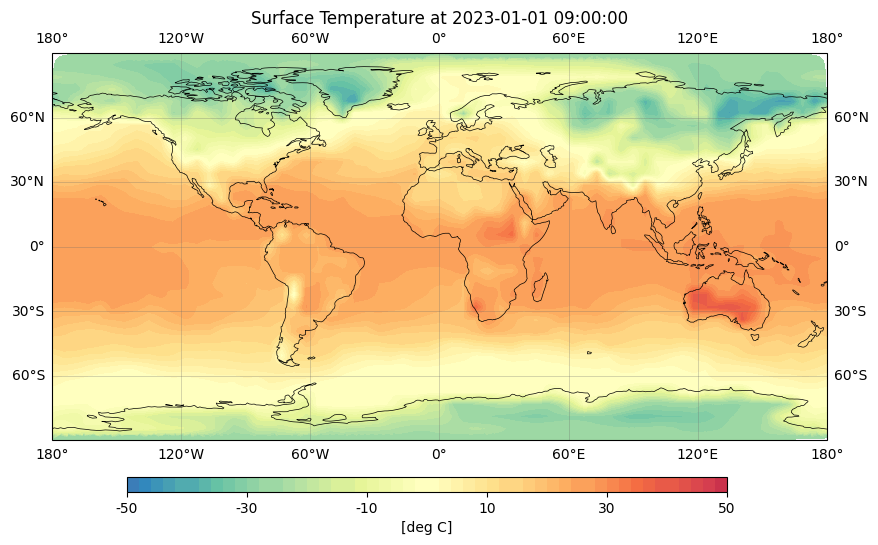

In [7]:
plotIconTemperatureGraph(ds=iconds, step=0)